# Q3: Integrated Gradients

In [1]:
import torch
import torchvision.models as models
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import torch
import torchvision.transforms as transforms
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch.nn.functional as F
import cv2


In [2]:
random.seed(42)  # For reproducibility

In [ ]:
model_path = 'resnet50_xray_neumonia-2.pt'  # Replace with your model path
healthy_folder = "/home/atoidze/final_preprocessed_dataset/test/NORMAL"  # Replace with path to folder containing healthy PNGs
disease_folder = "/home/atoidze/final_preprocessed_dataset/test/PNEUMONIA"  # Replace with path to folder containing disease PNGs

In [3]:
def load_model(model_path):
    try:
        # Try loading as a complete model
        model = torch.load(model_path, map_location=torch.device('cpu'))
        
        # Check if what was loaded is actually a state_dict (OrderedDict)
        if isinstance(model, dict) or isinstance(model, torch.nn.modules.module._IncompatibleKeys) or isinstance(model, collections.OrderedDict):
            print("Loaded file appears to be a state_dict, not a complete model")
            # Initialize a model to load the state_dict into
            base_model = models.resnet50(weights=None)  # Using weights=None instead of pretrained=True
            # Modify the final layer for binary classification (assuming binary)
            num_features = base_model.fc.in_features
            base_model.fc = torch.nn.Linear(num_features, 2)  # 2 classes
            # Load the state dict
            base_model.load_state_dict(model)
            model = base_model
            print("Successfully loaded state_dict into ResNet50 model")
        else:
            print("Loaded complete model")
    except Exception as e:
        print(f"Error during initial model loading: {e}")
        try:
            # Explicitly try loading as a state_dict
            base_model = models.resnet50(weights=None)  # Using weights=None instead of pretrained=True
            num_features = base_model.fc.in_features
            base_model.fc = torch.nn.Linear(num_features, 2)  # 2 classes
            base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
            model = base_model
            print("Loaded state_dict into ResNet50 with binary classification head")
        except Exception as e:
            print(f"Error loading state_dict: {e}")
            print("Falling back to pretrained ResNet50")
            model = models.resnet50(weights='IMAGENET1K_V1')  # Using weights parameter instead of pretrained
    
    model.eval()
    return model

In [5]:
def get_random_png_files(folder_path, n=5):
    """Get n random PNG files from the given folder"""
    all_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
    
    if len(all_files) < n:
        print(f"Warning: Only {len(all_files)} PNG files found in {folder_path}")
        return [os.path.join(folder_path, f) for f in all_files]
    
    selected_files = random.sample(all_files, n)
    return [os.path.join(folder_path, f) for f in selected_files]

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # Match your training transform
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Match your [-1,1] normalization
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    return input_tensor, image

In [ ]:
def apply_colormap_to_cam(cam):
    # Ensure cam is 2D: [H, W]
    if cam.ndim == 3:
        cam = np.mean(cam, axis=0)  # collapse channel if needed

    # Normalize cam to [0, 255] and convert to uint8
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # [0, 1]
    cam_heatmap = np.uint8(cam * 255)  # [H, W], dtype=uint8

    # Apply OpenCV colormap
    colored_cam = cv2.applyColorMap(cam_heatmap, cv2.COLORMAP_JET)  # [H, W, 3], BGR
    colored_cam = cv2.cvtColor(colored_cam, cv2.COLOR_BGR2RGB)      # Convert to RGB

    return colored_cam / 255.0  # Normalize to [0,1] float for overlay


def compute_ig_overlay(ig, input_tensor, original_image_np, target_class):
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    baseline = torch.zeros_like(input_tensor)

    attributions = ig.attribute(input_tensor, baselines=baseline, target=target_class, n_steps=50)
    attr = attributions.squeeze().cpu().detach().numpy()  # shape: [H, W]

    # Normalize attribution map
    attr = np.abs(attr)
    attr = (attr - np.min(attr)) / (np.max(attr) - np.min(attr) + 1e-8)

    # Apply OpenCV colormap
    heatmap = apply_colormap_to_cam(attr)  # shape: [H, W, 3]

    # Make sure original_image_np is RGB
    if original_image_np.ndim == 2:
        original_image_np = np.stack([original_image_np] * 3, axis=-1)  # shape: [H, W, 3]

    overlay = heatmap * 0.3 + original_image_np * 0.7
    overlay = overlay / overlay.max()

    return overlay


In [9]:
def get_correctly_classified_images(model, healthy_folder, disease_folder, num_samples=5):
    random.seed(42)

    all_healthy_images = get_random_png_files(healthy_folder, n=20)
    all_disease_images = get_random_png_files(disease_folder, n=20)

    correctly_classified_healthy = []
    correctly_classified_disease = []

    print("Finding correctly classified healthy images...")
    for img_path in all_healthy_images:
        input_tensor, _ = preprocess_image(img_path)
        with torch.no_grad():
            pred_class = torch.argmax(model(input_tensor)).item()
        if pred_class == 0:
            correctly_classified_healthy.append(img_path)
            print(f"  Found correctly classified healthy image: {os.path.basename(img_path)}")
        if len(correctly_classified_healthy) >= num_samples:
            break

    print("Finding correctly classified disease images...")
    for img_path in all_disease_images:
        input_tensor, _ = preprocess_image(img_path)
        with torch.no_grad():
            pred_class = torch.argmax(model(input_tensor)).item()
        if pred_class == 1:
            correctly_classified_disease.append(img_path)
            print(f"  Found correctly classified disease image: {os.path.basename(img_path)}")
        if len(correctly_classified_disease) >= num_samples:
            break

    return correctly_classified_healthy[:num_samples], correctly_classified_disease[:num_samples]

def visualize_integrated_gradients(model, healthy_paths, disease_paths, save_path="ig_attribution_maps_comparison.png"):
    from captum.attr import IntegratedGradients
    fig = plt.figure(figsize=(15, 10))
    num_samples = min(len(healthy_paths), len(disease_paths))
    gs = GridSpec(2, num_samples, figure=fig)

    ig = IntegratedGradients(model)

    print("Processing healthy images...")
    for i, img_path in enumerate(healthy_paths):
        input_tensor, original_image = preprocess_image(img_path)
        original_image_np = np.array(original_image.convert("L")) / 255.0
        # original_image_np = np.stack([original_image_np]*3, axis=-1)

        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = F.softmax(output, dim=1)[0, pred_class].item()

        overlay = compute_ig_overlay(ig, input_tensor, original_image_np, pred_class)
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(overlay)
        ax.set_title(f"{os.path.basename(img_path)}\nPred: Healthy ({confidence:.2f})")
        ax.axis('off')

    print("Processing disease images...")
    for i, img_path in enumerate(disease_paths):
        input_tensor, original_image = preprocess_image(img_path)
        original_image_np = np.array(original_image.convert("L")) / 255.0
        # original_image_np = np.stack([original_image_np]*3, axis=-1)

        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = F.softmax(output, dim=1)[0, pred_class].item()

        overlay = compute_ig_overlay(ig, input_tensor, original_image_np, pred_class)
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(overlay)
        ax.set_title(f"{os.path.basename(img_path)}\nPred: Disease ({confidence:.2f})")
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle("Integrated Gradients Attribution Maps: Correctly Classified Samples", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Visualization complete! Saved as '{save_path}'")



In [ ]:
def visualize_single_ig(model, img_path, save_path):
    ig = IntegratedGradients(model)

    # Preprocess image
    input_tensor, original_image = preprocess_image(img_path)
    original_image_np = np.array(original_image.convert("L")) / 255.0  # [H, W]

    # Model prediction
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    confidence = F.softmax(output, dim=1)[0, pred_class].item()

    # Compute IG attribution
    attributions_ig = ig.attribute(input_tensor, baselines=torch.zeros_like(input_tensor), target=pred_class, n_steps=50)
    attributions_ig = attributions_ig.squeeze(0).cpu().detach().numpy()  # [H, W]
    attributions_ig = np.transpose(attributions_ig, (1, 2, 0))
    np_input_img = input_tensor.squeeze(0).cpu().detach().numpy()  # [1, H, W]
    np_input_img = np.transpose(np_input_img, (1, 2, 0))  # [H, W, 1]


    # Right: IG Heatmap overlay
    fig, ax = viz.visualize_image_attr_multiple(
        attributions_ig,
        np_input_img,
        ["original_image", "heat_map"],
        ["all", "positive"],
        cmap="hot",
        show_colorbar=True,
    )

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [10]:
model = load_model('resnet50_xray_neumonia-2.pt')

Loaded file appears to be a state_dict, not a complete model
Successfully loaded state_dict into ResNet50 model


In [11]:
healthy_paths, disease_paths = get_correctly_classified_images(model, healthy_folder, disease_folder, num_samples=5)

Finding correctly classified healthy images...


  Found correctly classified healthy image: image_00150.png
  Found correctly classified healthy image: image_00100.png
  Found correctly classified healthy image: image_00051.png
  Found correctly classified healthy image: image_00010.png
  Found correctly classified healthy image: image_00187.png
Finding correctly classified disease images...
  Found correctly classified disease image: image_00435.png
  Found correctly classified disease image: image_00496.png
  Found correctly classified disease image: image_00437.png
  Found correctly classified disease image: image_00376.png
  Found correctly classified disease image: image_00331.png


In [14]:
healthy_paths

['/home/atoidze/final_preprocessed_dataset/test/NORMAL/image_00150.png',
 '/home/atoidze/final_preprocessed_dataset/test/NORMAL/image_00100.png',
 '/home/atoidze/final_preprocessed_dataset/test/NORMAL/image_00051.png',
 '/home/atoidze/final_preprocessed_dataset/test/NORMAL/image_00010.png',
 '/home/atoidze/final_preprocessed_dataset/test/NORMAL/image_00187.png']

In [15]:
disease_paths

['/home/atoidze/final_preprocessed_dataset/test/PNEUMONIA/image_00435.png',
 '/home/atoidze/final_preprocessed_dataset/test/PNEUMONIA/image_00496.png',
 '/home/atoidze/final_preprocessed_dataset/test/PNEUMONIA/image_00437.png',
 '/home/atoidze/final_preprocessed_dataset/test/PNEUMONIA/image_00376.png',
 '/home/atoidze/final_preprocessed_dataset/test/PNEUMONIA/image_00331.png']

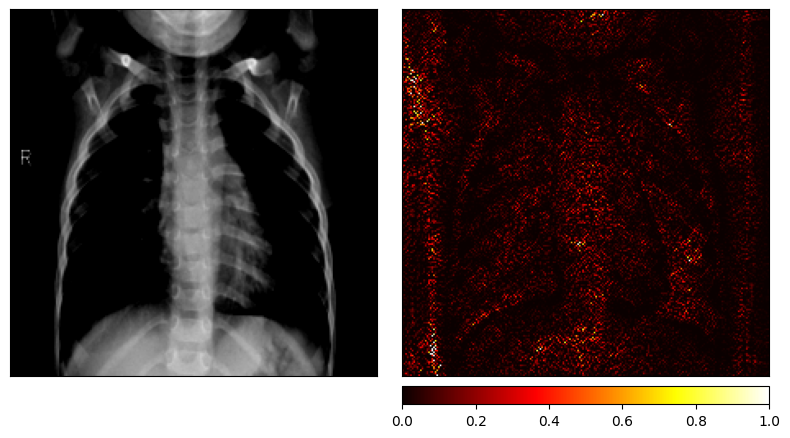

<Figure size 640x480 with 0 Axes>

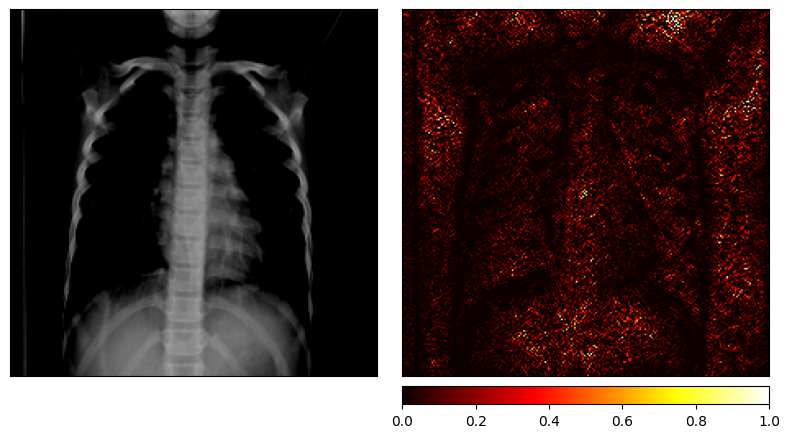

<Figure size 640x480 with 0 Axes>

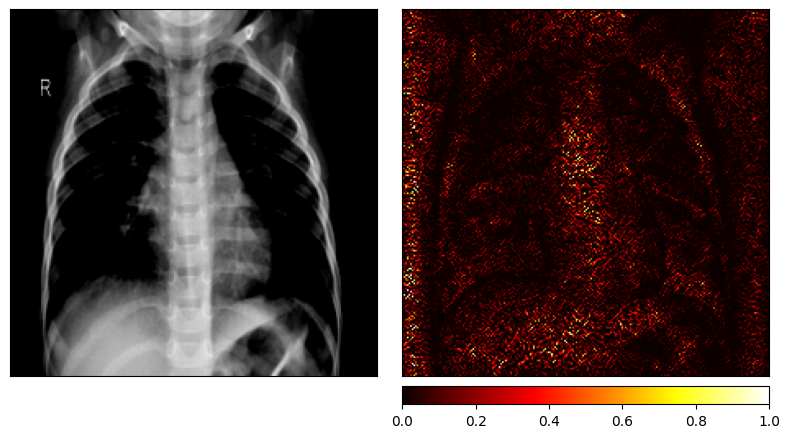

<Figure size 640x480 with 0 Axes>

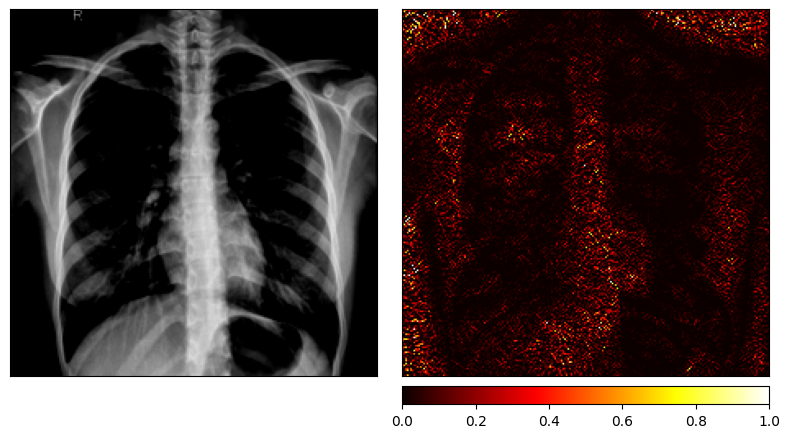

<Figure size 640x480 with 0 Axes>

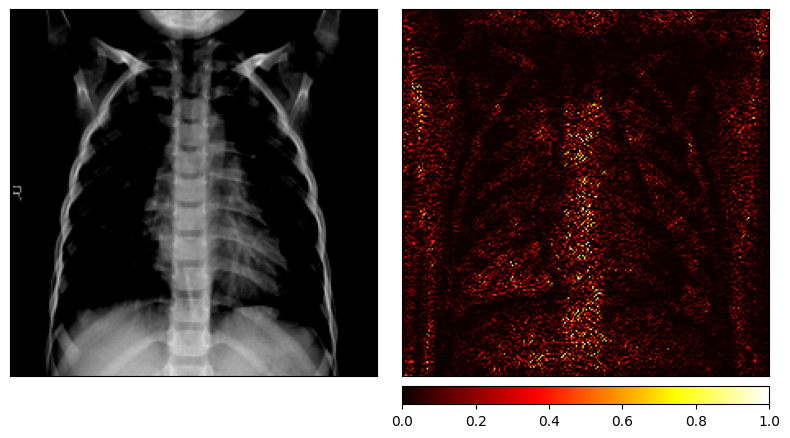

<Figure size 640x480 with 0 Axes>

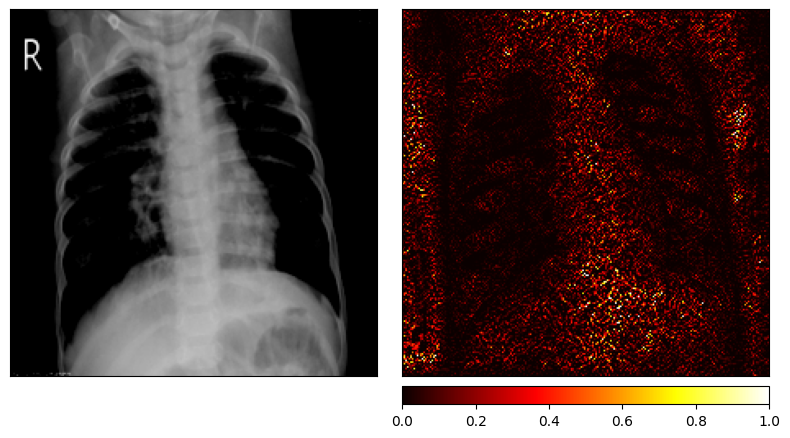

<Figure size 640x480 with 0 Axes>

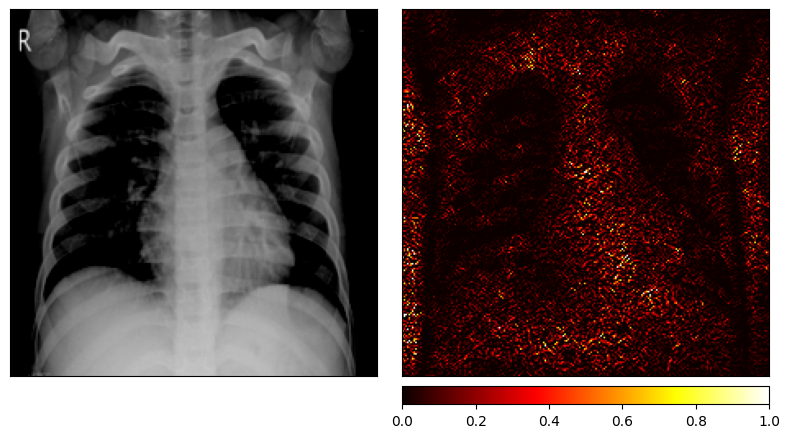

<Figure size 640x480 with 0 Axes>

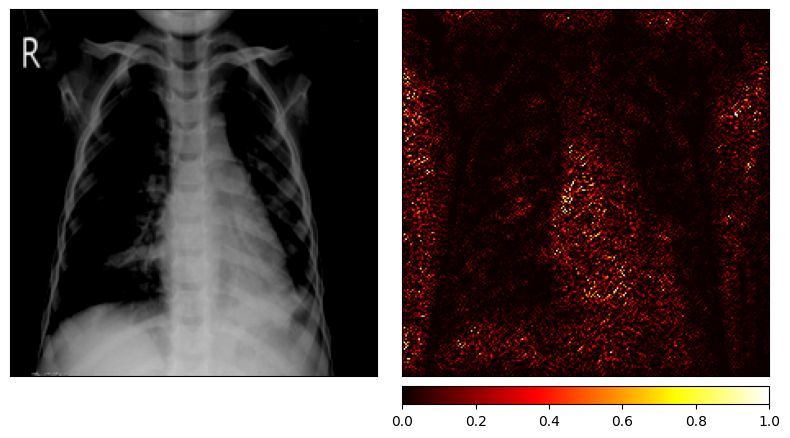

<Figure size 640x480 with 0 Axes>

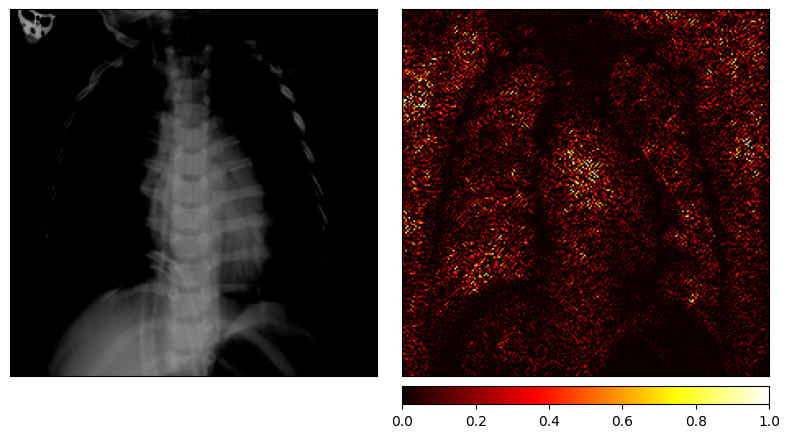

<Figure size 640x480 with 0 Axes>

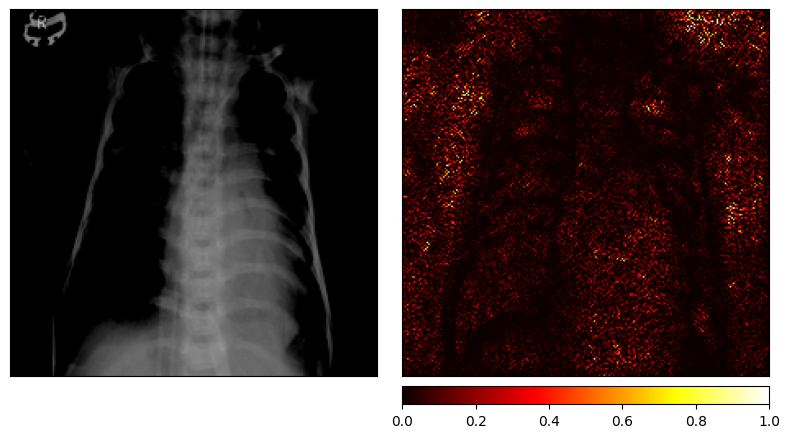

<Figure size 640x480 with 0 Axes>

In [30]:
# Save healthy samples
for img_path in healthy_paths:
    filename = f"healthy_{os.path.basename(img_path)}_ig.png"
    visualize_single_ig(model, img_path, save_path=filename)

# Save disease samples
for img_path in disease_paths:
    filename = f"disease_{os.path.basename(img_path)}_ig.png"
    visualize_single_ig(model, img_path, save_path=filename)

Processing healthy images...
Processing disease images...


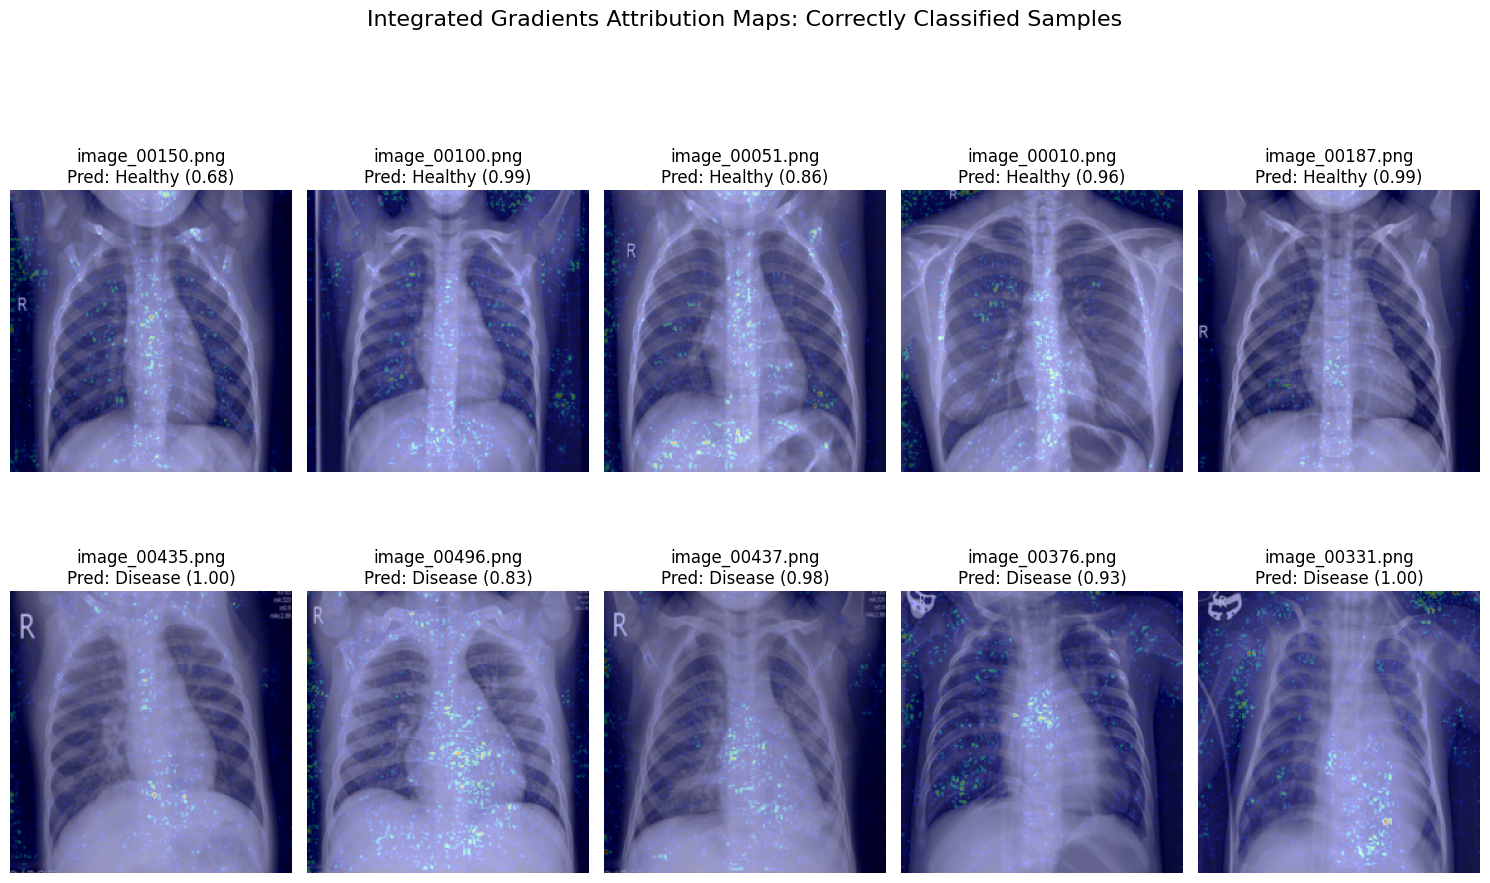

Visualization complete! Saved as 'ig_attribution_maps_comparison.png'


In [94]:
visualize_integrated_gradients(model, healthy_paths, disease_paths)